In [1]:
%load_ext autoreload
%autoreload 2
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy.io import fits

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfstats import sampling

from agrias import utils
import reader

In [3]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))

In [4]:
ms = reader.merianselect ( merian )

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:58: RuntimeWarning: overflow encountered in power
  av = 10.**np.poly1d(saga_gr_av_coeffs)(gr)


In [39]:
use_galex_direct = True

if use_galex_direct:
    _galex = pd.read_csv('../local_data/output/galex_photometry.csv', index_col=0)
    print(f'Direct photometry for {_galex.dropna().shape[0]} galaxies found.')
else:
    _galex = reader.galexcrossmatch ()    
    
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

if not use_galex_direct:
    _galex = _galex.sort_values('fuv_exptime', ascending=False)
galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap)#.reset_index()

if use_galex_direct:
    galex['fuv_mag'] = -2.5*np.log10(galex['flux_fuv']/3631.)
    galex['nuv_mag'] = -2.5*np.log10(galex['flux_nuv']/3631.)
else:
    galex['flux_fuv'] = np.where(galex['fuv_mag']>0., 10.**(galex['fuv_mag']/-2.5) * 3631., np.NaN)
    galex['flux_nuv'] = np.where(galex['nuv_mag']>0., 10.**(galex['nuv_mag']/-2.5) * 3631., np.NaN)
    galex['u_flux_fuv'] = (galex['fuv_mag']/galex['fuv_magerr'])**-1 * galex['flux_fuv']
    galex['u_flux_nuv'] = (galex['nuv_mag']/galex['nuv_magerr'])**-1 * galex['flux_nuv']
#merian_sources = table.Table.from_pandas(merian_sources.reset_index())

Direct photometry for 15443 galaxies found.


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
galex_mcat = reader.galexcrossmatch ()   
galex_mcat = galex_mcat.sort_values('fuv_exptime', ascending=False)
galex_mcat = galex_mcat.loc[~galex_mcat.index.duplicated(keep='first')]
galex_mcat.loc[galex_mcat['fuv_mag']<0., 'fuv_mag'] = np.NaN

In [41]:
out = reader.compute_halphacorrections(merian_sources, use_dustengine=False)
emission_correction, ge_correction, dust_correction, aperture_correction = out

Computed line contamination in 0.0 seconds.
Computed Galactic extinction in 0.1 seconds.
Computed internal extinction in 0.1 seconds.
Computed aperture correction in 0.0 seconds.


In [42]:
galex = reader.galex_luminosities(
    galex, 
    merian_sources['z_phot'].values, 
    ge_correction,# if not use_galex_direct else None, 
    dust_correction 
)
galex = galex.to_pandas()

In [43]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)

In [44]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(merian_sources.index)
print(f'Direct Ha photometry found for {lha_df.dropna().shape[0]} sources.')

Direct Ha photometry found for 15474 sources.


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


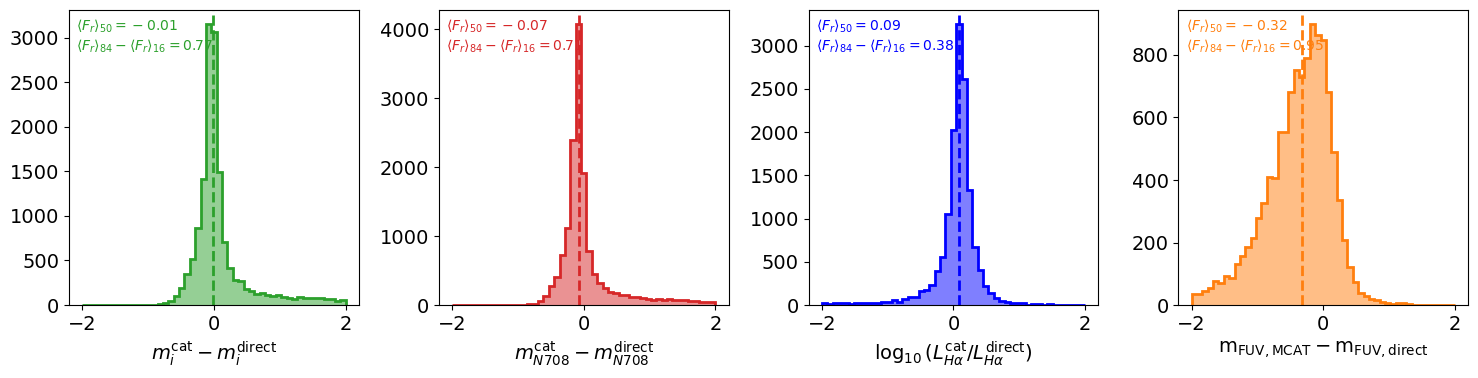

In [45]:
fig, axarr = plt.subplots(1,4,figsize=(15,4))
catalog_apercorr = merian_sources['i_cModelFlux_Merian'] / merian_sources['i_gaap1p0Flux_Merian']
f2m = lambda x, zp = 31.4: -2.5*np.log10(x*catalog_apercorr) + zp
ratios = [
    merian_sources['i_cModelmag_Merian'] - lha_df.reindex(merian_sources.index)['imag'],
    f2m(merian_sources['N708_gaap1p0Flux_Merian']) - lha_df.reindex(merian_sources.index)['n708mag'],    
    np.log10(catalog_halum['LHa']/1e40/lha_df.reindex(catalog_halum.index)['LHa']),
    galex_mcat.reindex(galex.index)['fuv_mag'] + 2.5*np.log10(ge_correction[:,0]) - galex['fuv_mag']
]
colorlist = [
    'tab:green',
    'tab:red',
    'b',
    'tab:orange'
]
labels = [
    r'$m_i^{\rm cat} - m_i^{\rm direct}$',
    r'$m_{N708}^{\rm cat} - m_{N708}^{\rm direct}$',
    r'$\log_{10}(L_{H\alpha}^{\rm cat}/L_{H\alpha}^{\rm direct})$',
    r'$\rm m_{\rm FUV, MCAT} - m_{FUV, direct}$'
]

for idx, ax in enumerate(axarr):
    ek.hist( 
        ratios[idx],
        bins=np.linspace(-2.,2.,50),
        ax=axarr[idx],
        color=colorlist[idx],
        alpha=0.5,
        lw=2
    )    
    axarr[idx].axvline(
        np.nanmedian(ratios[idx]),
        color=colorlist[idx],
        lw=2,
        ls='--'
    )
    ek.text(
        0.025,
        0.975,        
        r'''$\langle F_r \rangle_{50} = %.2f$
$\langle F_r \rangle_{84} - \langle F_r \rangle_{16} = %.2f$''' % (
    np.nanmedian(ratios[idx]), sampling.iqr(ratios[idx])
),
        ax=axarr[idx],
        color=colorlist[idx],
        fontsize=10
    )
    axarr[idx].set_xlabel(labels[idx])   
plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/photometric_offsets.png')

In [46]:
merr = np.log10(lha_df['LHa']*1e40 / galex.reindex(lha_df.index)['LFUV'])
hasnr = lha_df['LHa']/lha_df['u_LHa']
uvsnr = (galex['LFUV']/galex['u_LFUV']).reindex(lha_df.index)
#merr = np.where(np.isfinite(merr),merr, np.NaN)

In [47]:
df = pd.DataFrame ( index=lha_df.index, columns=['LFUV','u_LFUV','LHa','u_LHa'] )
df['LHa'] = lha_df['LHa']*1e40
df['u_LHa'] = lha_df['u_LHa']*1e40
df['LFUV'] = galex.reindex(lha_df.index)['LFUV']
df['u_LFUV'] = galex.reindex(lha_df.index)['u_LFUV']
df['R'] = df['LHa']/df['LFUV']
df['u_R'] = np.sqrt ( (df['u_LHa']/df['LFUV'])**2 + (df['LHa']/df['LFUV']**2 * df['u_LFUV'])**2)
df.dropna().to_csv('/Users/kadofong/Desktop/tmpx.csv')

In [48]:
from ekfstats import sampling

from ekfphys import calibrations, observer
from ekfparse import query

In [49]:
lee = table.Table.read('/Users/kadofong/work/projects/literature_ref/lee2009/tab1_processed.txt', format='mrt')
leer = lee['loghalum'] - lee['loguvlum']

In [50]:
snrbins = np.arange(1, 10, 0.25)
statsarr = np.zeros([len(snrbins),2])
for _,snr in enumerate(snrbins):
    sample = (df['R']/df['u_R'] > snr)&(df['LHa']<3e41)
    statsarr[_,0] = sampling.iqr(np.log10(df.loc[sample,'R']))
    statsarr[_,1] = np.median(np.log10(df.loc[sample,'R']))

Text(0, 0.5, '$\\langle \\mathcal{R} \\rangle_{84} - \\langle \\mathcal{R} \\rangle_{16}$')

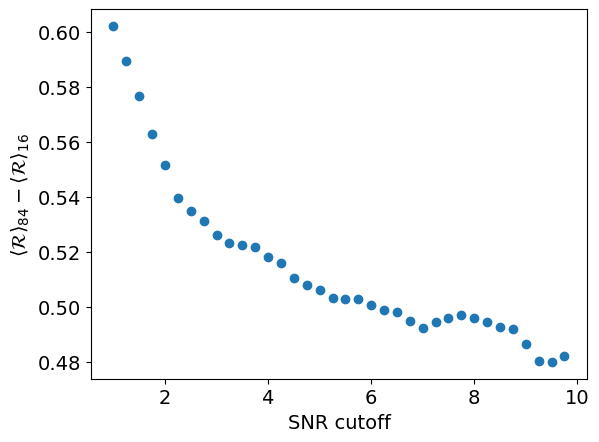

In [51]:
plt.plot ( snrbins, statsarr[:,0], 'o' )
plt.xlabel('SNR cutoff')
plt.ylabel(ek.common_labels['iqr'](r'\mathcal{R}'))

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:1002: RuntimeWarning: divide by zero encountered in divide
  ys = stretch*xspan*histout[0]/histout[0].max() + base
/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:1002: RuntimeWarning: invalid value encountered in divide
  ys = stretch*xspan*histout[0]/histout[0].max() + base
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


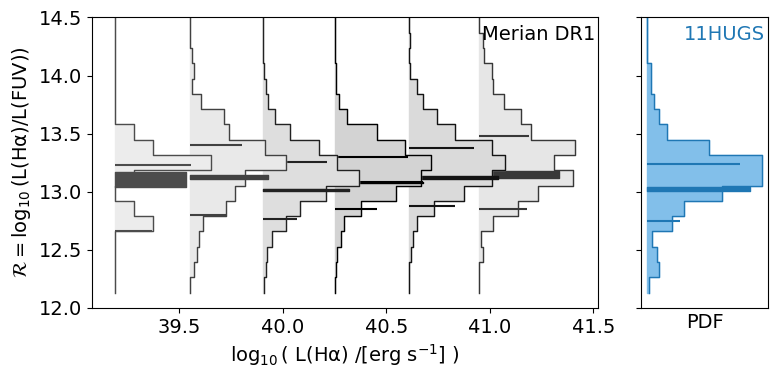

In [52]:
fig, axarr = plt.subplots(1,2,figsize=(8,4), gridspec_kw={'width_ratios':[4.,1.]}, sharey=True)

thresh = 6.
detection = (uvsnr>thresh)&(hasnr>thresh)
xbins = np.linspace(36.,41.4,15)
ybins = np.linspace(12.,14.5,20)
ek.histstack(
    np.log10(lha_df.loc[detection,'LHa']) + 40.,
    #np.log10(galex.reindex(lha_df.index)['LFUV'])[detection],
    merr[detection],
    #density=True,
    xbins=xbins,
    ybins=ybins,
    ax=axarr[0]
)
out=ek.histstack(
    lee['loghalum'],
    leer,
    xbins = np.array([xbins.min(), xbins.max()]),
    ybins=ybins,
    #orientation='horizontal',
    edgecolor='C0',
    facecolor=ec.ColorBase('C0').modulate(0.3).base,
    quantilecolor='C0',
    ax=axarr[1]
)

axarr[0].set_ylim(12.,14.5)

axarr[0].set_xlabel(ek.convert_label_to_log(ek.common_labels['halum']))
axarr[0].set_ylabel(ek.common_labels['hauv'])

axarr[1].set_xticks([])
axarr[1].set_xlabel('PDF')

ek.text(0.995,0.975,'Merian DR1', ax=axarr[0])
ek.text(
    0.975,
    0.975,
    '11HUGS',
    color='C0',
    ax=axarr[1]
)
plt.tight_layout ()
plt.savefig('/Users/kadofong/Desktop/lha_v_lee.png')

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '$\\mathcal{R}$, catalog H$\\alpha$')

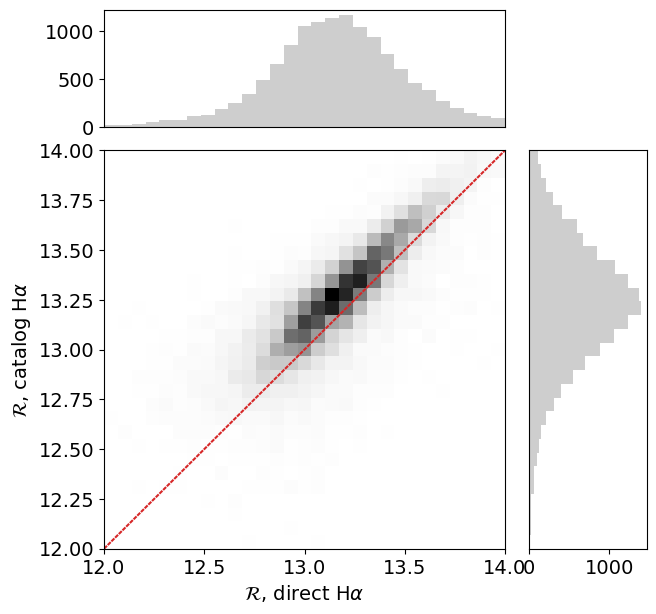

In [54]:
out,axarr=ek.hist2d(
    np.log10(lha_df['LHa']*1e40 / galex.reindex(lha_df.index)['LFUV']),
    np.log10(catalog_halum['LHa'] / galex.reindex(catalog_halum.index)['LFUV']),
    bins=[np.linspace(12.,14.,30),np.linspace(12.,14.,30)],
    show_proj=True
)
xs = np.array([12.,14.])
axarr[0].plot(xs,xs,color='tab:red', dashes=[2.,.5])
axarr[0].set_xlabel(r'$\mathcal{R}$, direct H$\alpha$')
axarr[0].set_ylabel(r'$\mathcal{R}$, catalog H$\alpha$')

,LHa,u_LHa,imag,n708mag
M3324804415138851598,NaN,NaN,NaN,NaN
M3324808813185374186,NaN,NaN,NaN,NaN
M3324808813185374188,NaN,NaN,NaN,NaN
M3324813211231881880,NaN,NaN,NaN,NaN
M3324822007324907668,NaN,NaN,NaN,NaN
...,...,...,...,...
M3339216813555746526,0.701284,0.158901,19.727895,19.845067
M3339251997927828822,NaN,NaN,NaN,NaN
M3339256395974337725,17.451674,0.232010,18.321716,18.088790
M3339291580346429639,1.732644,0.163842,19.707903,19.617674
